# Çizge Sinir Ağları ile Çizge Sınıflandırma

Bu defterde, **Çizge Sinir Ağlarının (GNN'ler) çizge sınıflandırma görevine** nasıl uygulanacağına daha yakından bakacağız. Çizge sınıflandırması, bir **çizge veri kümesi** verildiğinde bazı yapısal çizge özelliklerine dayalı olarak tüm çizgelerin (noktaların aksine) sınıflandırma sorununu ele alır. Burada tüm çizgeleri yerleştirmek istiyoruz, ve bu yerleştirmenin de, bir ML görevi için doğrusal olarak çizgeleri ayırabilecek bir şekilde olmasını istiyoruz.

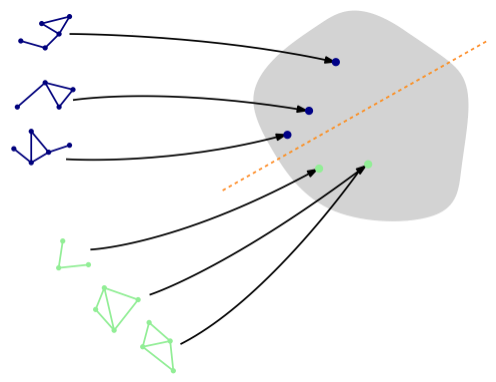

Çizge sınıflandırması için en yaygın görev, moleküllerin çizgeler olarak temsil edildiği **moleküler özellik tahminidir** ve görev, bir molekülün HIV virüsü replikasyonunu inhibe edip etmediğini anlamak olabilir.

Literatürde, TU Dortmund Üniversitesi, [**TUDatasets**](https://chrsmrrs.github.io/datasets/) olarak bilinen ve [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) üzerinden erişilebilen, popüler bir veri kümesi vardır. Bu verilerden görece küçük olanlardan birini, **MUTAG veri kümesini** yükleyip inceleyelim:

In [1]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Veri kümesi: {dataset}:')
print('====================')
print(f'Çizgelerin sayısı: {len(dataset)}')
print(f'Özellik sayısı: {dataset.num_features}')
print(f'Sınıf sayısı: {dataset.num_classes}')

data = dataset[0]  # Örnek olarak ilk çizgeye bakalım

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Noktaların sayısı: {data.num_nodes}')
print(f'Kenarların sayısı: {data.num_edges}')
print(f'Bir noktanın ortalama kenar sayısı: {data.num_edges / data.num_nodes:.2f}')
print(f'Çizgede ayrık nokta var mı: {data.contains_isolated_nodes()}')
print(f'Çizgede döngüler var mı: {data.contains_self_loops()}')
print(f'Çizge yönsüz mü: {data.is_undirected()}')


Veri kümesi: MUTAG(188):
Çizgelerin sayısı: 188
Özellik sayısı: 7
Sınıf sayısı: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Noktaların sayısı: 17
Kenarların sayısı: 38
Bir noktanın ortalama kenar sayısı: 2.24
Çizgede ayrık nokta var mı: False
Çizgede döngüler var mı: False
Çizge yönsüz mü: True


/Users/kamer/opt/anaconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/Users/kamer/opt/anaconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Bu veri kümesi **188 farklı çizge** içermektedir ve görev, her çizgeyi **iki sınıftan birine** sınıflandırmaktır.

Veri kümesinin ilk çizge nesnesini inceleyerek, **17 nokta (7 boyutlu özellik vektörleri ile)** ve **38 kenar** (ortalama kenar sayısı 2.24) ile geldiğini görebiliriz. Ayrıca her çizge **bir etiketi** (`y=[1]`) ile birlikte gelir ve önceki veri kümelerine ek olarak ek **4 boyutlu kenar özellikleri** sağlar (`edge_attr=[38, 4]). `).
Ancak, bu defterde, kenar özelliklerinden yararlanmayacağız.

PyTorch Geometric, şu ana kadar öğrendiğimiz gibi çizge veri kümeleriyle çalışmak için faydalı araçlar sağlar, *örneğin*, biz bu çizge veri kümesini karıştırabilir, ilk 150 çizgeyi eğitim verisi olarak kullanabilir, geri kalanları ise test için kullanabiliriz:

In [2]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Eğitim için kullanılacak çizge sayısı: {len(train_dataset)}')
print(f'Test için kullanılacak çizge sayısı: {len(test_dataset)}')

Eğitim için kullanılacak çizge sayısı: 150
Test için kullanılacak çizge sayısı: 38


## Çizgeler için gruplar oluşturmak 

Çizge sınıflandırma veri kümelerindeki çizge genellikle küçük olduğundan, tam GPU kullanımını garanti etmek için bir Çizge Sinir Ağı'na girmeden önce **çizgeleri gruplamak** iyi bir fikirdir. Bu boyutun uzunluğu daha sonra bir grupta bir araya getirilmiş örneklerin sayısına eşittir ve tipik olarak `batch_size` olarak adlandırılır.
PyTorch Geometric'te bitişik matrisler diyagonal bir şekilde istiflenir (birden çok ayrık alt çizgeyi tutan dev bir çizge oluşturur) ve nokta ve hedef özellikleri, nokta boyutunda basitçe birleştirilir:

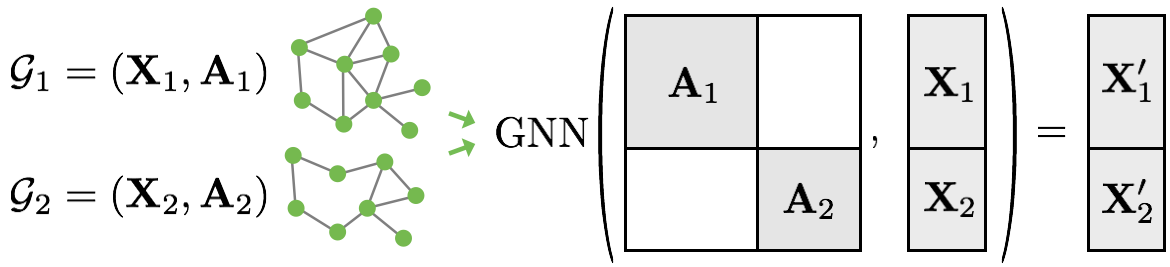

Bu prosedür klasik gruplama işlemine göre şu nedenlerden dolayı avantajlıdır:

1. Farklı çizgelere ait noktalar hep aynı grupta bulunduğundan, mesaj paylaşımı yöntemlerinin değiştirilmesine gerek yoktur. 

2. Her ne kadar büyük çizge matrisi gereksiz boş değerler içeriyor gibi gözükse de bu aşamada seyrek matris (ya da çizge) veri yapıları kullanıldığından hafıza ve hesaplama açısından bir kayıp olmaz. 

PyTorch Geometric bu işlemi [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) modülü ile otomatik olarak halleder. 

In [3]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Adım {step + 1}:')
    print('=======')
    print(f'Bu gruptaki çizge sayısı: {data.num_graphs}')
    print(data)
    print()

Adım 1:
Bu gruptaki çizge sayısı: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Adım 2:
Bu gruptaki çizge sayısı: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Adım 3:
Bu gruptaki çizge sayısı: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



/Users/kamer/opt/anaconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Yukarıdaki `train_loader` ve `test_loader` için kullanılan `batch_size` değeri 64'tür. Bu şekilde $2$ grup ile $2 \cdot 64+22 = 150$ çizge kapsanabilir. 

Bunun yanında bütün `Batch` nesneleri yukarıda gözükmeyen bir **`batch` vektörü** içermektedir. Bu vektördeki idler, grup içerisinde bulunan çizgeleri orjinal çizgelere eşler. 

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ] 
$$ gibi...

## Çizge Sınıflandırma için Çizge Sinir Ağı (GNN) Eğitimi

Daha önce de yaptığımız işlemlere benzer bir şekilde, bu işlemi de basit adımlarla gerçekleştireceğiz. Bunlardan ilki daha önce yaptığımız nokta yerleştirme adımı olacak. 

1. Her noktanın yerleşiminin bulunması.  
2. Nokta yerleşim vektörlerinin bir araya getirilim bir çizge yerleşiminin bulunması (**readout layer**).
3. Bir üsteki adımdan elde edilen çıktılar için bir sınıflandırıcı eğitimi. 

Literatürde kullanılan birçok **readout katmanı** vardır. Bunlardan en basiti ve belki de en sık kullanılanı nokta yerleşimlerinin ortalamasını alan bir araya getirme yöntemidir.  

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric bu yöntemi [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool) modeli altında sağlar. Bu işlem grubun içerisindeki nokta yerleşimlerini ve `batch` vektörünü kullanarak, her çizge için `[batch_size, hidden_channels]` şeklinde bir yerleştirme hesaplar.

Bu yapıyı gerçekleyelim.

In [4]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Nokta yerleştirmelerini elde edelim
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout katmanı
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Son bir sınıflandırıcı katmanı
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


Bu ağ için temel olarak [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) katmanlarını kullandık. bu katmanlar, kendi içerisinde $\mathrm{ReLU}(x) = \max(x, 0)$ aktivasyon fonksiyonunu kullanmaktadır. 

Eğitim işlemini gerçekleştirelim. 

In [5]:
model = GCN(hidden_channels = 64)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Bütün gruplar üzerinden ilerleyelim.
        out = model(data.x, data.edge_index, data.batch)  # İleri adım. 
        loss = criterion(out, data.y)  # Kayıp fonksiyonunu hesapla.
        loss.backward()  # Türevlerin hesabı.
        optimizer.step()  # Parametrelerin güncellenmesi.
        optimizer.zero_grad()  # Türevlerin temizlenmesi.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Gruplar üzerinden ilerleyelim.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # En yüksek olasılığa sahip sınıfı kullanalım.
        correct += int((pred == data.y).sum())  # Derçek değerlerle karşılaştıralım.
    return correct / len(loader.dataset)  # Doğruluk değerini hesaplayalım.

for epoch in range(1, 50):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Döngü: {epoch:03d}, Eğitim doğruluğu: {train_acc:.4f}, Test doğruluğu: {test_acc:.4f}')

Döngü: 001, Eğitim doğruluğu: 0.6467, Test doğruluğu: 0.7368
Döngü: 002, Eğitim doğruluğu: 0.6467, Test doğruluğu: 0.7368
Döngü: 003, Eğitim doğruluğu: 0.6467, Test doğruluğu: 0.7368
Döngü: 004, Eğitim doğruluğu: 0.6467, Test doğruluğu: 0.7368
Döngü: 005, Eğitim doğruluğu: 0.6467, Test doğruluğu: 0.7368
Döngü: 006, Eğitim doğruluğu: 0.6533, Test doğruluğu: 0.7368
Döngü: 007, Eğitim doğruluğu: 0.7467, Test doğruluğu: 0.7632
Döngü: 008, Eğitim doğruluğu: 0.7267, Test doğruluğu: 0.7632
Döngü: 009, Eğitim doğruluğu: 0.7200, Test doğruluğu: 0.7632
Döngü: 010, Eğitim doğruluğu: 0.7133, Test doğruluğu: 0.7895
Döngü: 011, Eğitim doğruluğu: 0.7200, Test doğruluğu: 0.7632
Döngü: 012, Eğitim doğruluğu: 0.7200, Test doğruluğu: 0.7895
Döngü: 013, Eğitim doğruluğu: 0.7200, Test doğruluğu: 0.7895
Döngü: 014, Eğitim doğruluğu: 0.7133, Test doğruluğu: 0.8421
Döngü: 015, Eğitim doğruluğu: 0.7133, Test doğruluğu: 0.8421
Döngü: 016, Eğitim doğruluğu: 0.7533, Test doğruluğu: 0.7368
Döngü: 017, Eğitim doğru

Burada görüldüğü gibi modelimiz iyi bir test doğruluğuna ulaşabiliyor.

## Soru

Daha iyisini yapabilir miyiz? Literatürdeki birçok makalenin, (örneğin 
[Xu et al. (2018)](https://arxiv.org/abs/1810.00826), [Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), gösterdiği gibi **komşuluk normalizasyonu GNN'lerin çizgeleri sınıflandırma gücünü bazı özel çizge yapıları için azaltmaktadır.**.
Alternatif bir formül ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)) tarafından önerilmiştir. Bu formülde normalizasyon işlemi yapılmaz:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

Bu katman PyTorch Geometric'de [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) modülünde gerçeklenmiştir.

Bir egzersiz olarak, aşağıdaki PyG kodunu `GCNConv` ile değil `GraphConv` ile tamamlayalım. Bu yöntem ile **80%'den fazla bir doğruluk değeri elde edilecektir**.

In [6]:
from torch_geometric.nn import GraphConv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 50):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.7333, Test Acc: 0.7895
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.7333, Test Acc: 0.8158
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.8158
Epoch: 009, Train Acc: 0.7867, Test Acc: 0.8421
Epoch: 010, Train Acc: 0.7733, Test Acc: 0.8158
Epoch: 011, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 012, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 013, Train Acc: 0.7733, Test Acc: 0.8421
Epoch: 014, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 015, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 016, Train Acc: 0.7667, Test Acc: 0.7632
Epoch: 017, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 018, Train Acc: 0.7867, Test Acc: 0.7895
Epoch: 019, Train Acc: 0.7867, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.8133, Test Acc: 0.8421
Epoch: 021, Train Acc: 0.8000, Test Acc: